### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

# Latent dimensions
z = 10
# Training iterations
iter_max = 100
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)

    return train_loader, test_loader, (X_test, y_test)

train_loader, test_loader, _ = get_mnist_data(device, batch_size)
train_loader

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [3]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    ################################################################################
    # TODO: complete the code here
    # Task: Sample z


    # Generate random samples from a standard normal distribution
    epsilon = torch.randn_like(v)

    # Reparameterization trick
    z = m + torch.sqrt(v) * epsilon


    # End
    ################################################################################

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob

def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))

def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()

### Base Models

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the functions ```negative_elbo_bound``` and ```negative_iwae_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [5]:
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: complete the code here
        # Task: Compute negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        # Outputs should all be scalar

        # Encode input
        mean, variance = self.enc.encode(x)

        # Sample from the encoded distribution
        z = sample_gaussian(mean, variance)

        # Decode the sampled representation
        logits = self.dec.decode(z)

        # Calculate KL divergence, reconstruction error, and negative ELBO
        # kl = kl_normal(mean, variance, self.z_prior[0], self.z_prior[1])

        kl = kl_normal(mean, variance, self.z_prior_m, self.z_prior_v)
        rec = -log_bernoulli_with_logits(x, logits)
        nelbo = kl + rec


        # End
        ################################################################################

        return nelbo.mean(), kl.mean(), rec.mean()

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: Modify/complete the code here
        # Compute niwae (negative IWAE) with iw importance samples, and the KL
        # and Rec decomposition of the Evidence Lower Bound
        #
        # Outputs should all be scalar
        ################################################################################


        # Encoding
        m, v = self.enc.encode(x)

        # Duplicate samples
        m, v, x = map(lambda t: t.repeat(iw, 1), (m, v, x))


        # Sample from the Gaussian distribution
        z = sample_gaussian(m, v)

        # Decoding
        logits = self.dec.decode(z)

        # Compute KL divergence
        kl = log_normal(z, m, v) - log_normal(z, self.z_prior[0], self.z_prior[1])

        # Compute reconstruction term
        rec = -log_bernoulli_with_logits(x, logits)

        # Compute NELBO (Negative ELBO)
        nelbo = kl + rec

        # Compute negative importance-weighted ELBO
        niwae = -log_mean_exp(-nelbo.reshape(iw, -1), dim=0)

        # Take mean over importance-weighted samples
        niwae, kl, rec = niwae.mean(), kl.mean(), rec.mean()



        ################################################################################
        # End of code modification
        ################################################################################
        return niwae, kl, rec


    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100.

In [18]:

# vae = VAE(z_dim=z).to(device)
# optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# for i in tqdm(range(iter_max)):
#     for batch_idx, (xu, yu) in enumerate(train_loader):

#         optimizer.zero_grad()

#         xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
#         yu = yu.new(np.eye(10)[yu]).to(device).float()
#         loss, summaries = vae.loss(xu)

#         loss.backward()
#         optimizer.step()

#     print(summaries['train/loss'])

#     ################################################################################
#     # TODO: complete the code here
#     # report the loss terms across time for train and validation datasets
#     #
#     # You can choose to only perform validation once in every 10 (Or any other number
#     # depending on the speed of the algorithm on your machine) iterations and display
#     # the training and validation statistics on those iterataions.

#     # End
#     ################################################################################

In [27]:
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Initialize VAE and optimizer
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Lists to store the loss terms during training and test
train_losses = []
train_kls = []
train_recs = []
test_losses = []
test_kls = []
test_recs = []

# Training loop
for epoch in tqdm(range(iter_max)):
    vae.train()  # Set the model to training mode

    for batch_idx, (xu, yu) in enumerate(train_loader):
        optimizer.zero_grad()

        # Convert input to binary and one-hot encode labels
        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()

        # Calculate loss and backpropagate
        loss, summaries = vae.loss(xu)
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        # Training dataset
        vae.eval()  # Set the model to evaluation mode

        # Lists to store individual batch losses during an epoch
        epoch_train_losses = []
        epoch_train_kls = []
        epoch_train_recs = []

        for batch_idx, (xu, yu) in enumerate(train_loader):
            xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
            yu = yu.new(np.eye(10)[yu]).to(device).float()
            train_loss, train_kl, train_rec = vae.negative_elbo_bound(xu)

            epoch_train_losses.append(train_loss.item())
            epoch_train_kls.append(train_kl.item())
            epoch_train_recs.append(train_rec.item())

        ## Track training components
        # train_losses.append(summaries['train/loss'])
        # train_kls.append(summaries['gen/kl_z'])
        # train_recs.append(summaries['gen/rec'])

        # Calculate the mean of losses for the epoch
        mean_train_loss = np.mean(epoch_train_losses)
        mean_train_kl = np.mean(epoch_train_kls)
        mean_train_rec = np.mean(epoch_train_recs)

        train_losses.append(mean_train_loss)
        train_kls.append(mean_train_kl)
        train_recs.append(mean_train_rec)

        print(f"Epoch {epoch + 1}/{iter_max} - Training Negative ELBO: {mean_train_loss}, KL Divergence: {mean_train_kl}, Reconstruction Loss: {mean_train_rec}")

        # Validation dataset
        epoch_test_losses = []
        epoch_test_kls = []
        epoch_test_recs = []

        for batch_idx, (xv, yv) in enumerate(test_loader):
            xv = torch.bernoulli(xv.to(device).reshape(xv.size(0), -1))
            yv = yv.new(np.eye(10)[yv]).to(device).float()
            test_loss, test_kl, test_rec = vae.negative_elbo_bound(xv)

            epoch_test_losses.append(test_loss.item())
            epoch_test_kls.append(test_kl.item())
            epoch_test_recs.append(test_rec.item())

        # Calculate the mean of losses for the epoch
        mean_test_loss = np.mean(epoch_test_losses)
        mean_test_kl = np.mean(epoch_test_kls)
        mean_test_rec = np.mean(epoch_test_recs)

        test_losses.append(mean_test_loss)
        test_kls.append(mean_test_kl)
        test_recs.append(mean_test_rec)

        print(f"Epoch {epoch + 1}/{iter_max} - Validation Negative ELBO: {mean_test_loss}, KL Divergence: {mean_test_kl}, Reconstruction Loss: {mean_test_rec}")


torch.save(vae, 'vae_model.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Training Negative ELBO: 198.5472765604655, KL Divergence: 4.1948851903279625, Reconstruction Loss: 194.35239232381184


  1%|          | 1/100 [00:14<23:48, 14.43s/it]

Epoch 1/100 - Validation Negative ELBO: 198.33309020996094, KL Divergence: 4.239858913421631, Reconstruction Loss: 194.09322662353514
Epoch 2/100 - Training Negative ELBO: 172.28439356486004, KL Divergence: 8.702034648259481, Reconstruction Loss: 163.5823621114095


  2%|▏         | 2/100 [00:28<23:24, 14.33s/it]

Epoch 2/100 - Validation Negative ELBO: 171.59768676757812, KL Divergence: 8.839736461639404, Reconstruction Loss: 162.7579574584961
Epoch 3/100 - Training Negative ELBO: 150.28177286783855, KL Divergence: 11.575551843643188, Reconstruction Loss: 138.70622024536132


  3%|▎         | 3/100 [00:42<23:03, 14.26s/it]

Epoch 3/100 - Validation Negative ELBO: 149.4546661376953, KL Divergence: 11.680010509490966, Reconstruction Loss: 137.7746597290039
Epoch 4/100 - Training Negative ELBO: 139.22146962483723, KL Divergence: 12.587604506810505, Reconstruction Loss: 126.63386446634928


  4%|▍         | 4/100 [00:57<22:49, 14.27s/it]

Epoch 4/100 - Validation Negative ELBO: 138.1192199707031, KL Divergence: 12.670882511138917, Reconstruction Loss: 125.44833450317383
Epoch 5/100 - Training Negative ELBO: 132.69733276367188, KL Divergence: 13.714613882700602, Reconstruction Loss: 118.98271827697754


  5%|▌         | 5/100 [01:11<22:52, 14.44s/it]

Epoch 5/100 - Validation Negative ELBO: 131.73341522216796, KL Divergence: 13.783533382415772, Reconstruction Loss: 117.9498794555664
Epoch 6/100 - Training Negative ELBO: 128.43181393941242, KL Divergence: 14.184671878814697, Reconstruction Loss: 114.2471415201823


  6%|▌         | 6/100 [01:26<22:43, 14.51s/it]

Epoch 6/100 - Validation Negative ELBO: 127.5068748474121, KL Divergence: 14.234821605682374, Reconstruction Loss: 113.27205276489258
Epoch 7/100 - Training Negative ELBO: 124.97672678629557, KL Divergence: 14.84873096148173, Reconstruction Loss: 110.12799606323242


  7%|▋         | 7/100 [01:40<22:24, 14.46s/it]

Epoch 7/100 - Validation Negative ELBO: 123.97903747558594, KL Divergence: 14.878484058380128, Reconstruction Loss: 109.10055541992188
Epoch 8/100 - Training Negative ELBO: 122.5061762491862, KL Divergence: 15.525386412938436, Reconstruction Loss: 106.98079020182291


  8%|▊         | 8/100 [01:55<22:14, 14.51s/it]

Epoch 8/100 - Validation Negative ELBO: 121.57195663452148, KL Divergence: 15.565339374542237, Reconstruction Loss: 106.00661544799804
Epoch 9/100 - Training Negative ELBO: 120.02449289957683, KL Divergence: 15.989467207590739, Reconstruction Loss: 104.0350269317627


  9%|▉         | 9/100 [02:09<21:58, 14.49s/it]

Epoch 9/100 - Validation Negative ELBO: 118.88271026611328, KL Divergence: 16.030708980560302, Reconstruction Loss: 102.85199890136718
Epoch 10/100 - Training Negative ELBO: 118.05506248474121, KL Divergence: 16.375513331095377, Reconstruction Loss: 101.67954915364584


 10%|█         | 10/100 [02:24<21:43, 14.48s/it]

Epoch 10/100 - Validation Negative ELBO: 116.93548355102538, KL Divergence: 16.405274200439454, Reconstruction Loss: 100.53021011352538
Epoch 11/100 - Training Negative ELBO: 116.54314193725585, KL Divergence: 16.714894008636474, Reconstruction Loss: 99.82824783325195


 11%|█         | 11/100 [02:38<21:27, 14.46s/it]

Epoch 11/100 - Validation Negative ELBO: 115.47662048339843, KL Divergence: 16.74936294555664, Reconstruction Loss: 98.7272575378418
Epoch 12/100 - Training Negative ELBO: 115.27227312723795, KL Divergence: 16.850832970937095, Reconstruction Loss: 98.42143987019857


 12%|█▏        | 12/100 [02:53<21:10, 14.44s/it]

Epoch 12/100 - Validation Negative ELBO: 114.1828399658203, KL Divergence: 16.87488136291504, Reconstruction Loss: 97.3079620361328
Epoch 13/100 - Training Negative ELBO: 114.27511812845866, KL Divergence: 17.011166477203368, Reconstruction Loss: 97.26395047505697


 13%|█▎        | 13/100 [03:07<20:53, 14.41s/it]

Epoch 13/100 - Validation Negative ELBO: 113.24859771728515, KL Divergence: 17.035114097595216, Reconstruction Loss: 96.21348342895507
Epoch 14/100 - Training Negative ELBO: 113.29863001505534, KL Divergence: 17.153720951080324, Reconstruction Loss: 96.1449099222819


 14%|█▍        | 14/100 [03:21<20:37, 14.39s/it]

Epoch 14/100 - Validation Negative ELBO: 112.21300354003907, KL Divergence: 17.17330322265625, Reconstruction Loss: 95.03969650268554
Epoch 15/100 - Training Negative ELBO: 112.53324445088704, KL Divergence: 17.5616016070048, Reconstruction Loss: 94.9716433207194


 15%|█▌        | 15/100 [03:36<20:23, 14.39s/it]

Epoch 15/100 - Validation Negative ELBO: 111.48945999145508, KL Divergence: 17.597143363952636, Reconstruction Loss: 93.89231719970704
Epoch 16/100 - Training Negative ELBO: 111.68336181640625, KL Divergence: 17.448443285624187, Reconstruction Loss: 94.23491999308268


 16%|█▌        | 16/100 [03:50<20:05, 14.35s/it]

Epoch 16/100 - Validation Negative ELBO: 110.64159088134765, KL Divergence: 17.470471954345705, Reconstruction Loss: 93.17111892700196
Epoch 17/100 - Training Negative ELBO: 110.96483535766602, KL Divergence: 17.585936800638834, Reconstruction Loss: 93.37889938354492


 17%|█▋        | 17/100 [04:05<19:54, 14.39s/it]

Epoch 17/100 - Validation Negative ELBO: 110.12772598266602, KL Divergence: 17.598286437988282, Reconstruction Loss: 92.52943572998046
Epoch 18/100 - Training Negative ELBO: 110.3621597290039, KL Divergence: 17.700646336873373, Reconstruction Loss: 92.66151250203451


 18%|█▊        | 18/100 [04:19<19:35, 14.34s/it]

Epoch 18/100 - Validation Negative ELBO: 109.57553482055664, KL Divergence: 17.720572662353515, Reconstruction Loss: 91.85496292114257
Epoch 19/100 - Training Negative ELBO: 109.85056622823079, KL Divergence: 17.694786802927652, Reconstruction Loss: 92.15577901204428


 19%|█▉        | 19/100 [04:33<19:22, 14.35s/it]

Epoch 19/100 - Validation Negative ELBO: 108.94110794067383, KL Divergence: 17.707955741882323, Reconstruction Loss: 91.23315658569337
Epoch 20/100 - Training Negative ELBO: 109.33653551737467, KL Divergence: 17.888194020589193, Reconstruction Loss: 91.44834073384602


 20%|██        | 20/100 [04:48<19:12, 14.41s/it]

Epoch 20/100 - Validation Negative ELBO: 108.35234375, KL Divergence: 17.886996841430665, Reconstruction Loss: 90.4653450012207
Epoch 21/100 - Training Negative ELBO: 108.86039772033692, KL Divergence: 17.829707686106364, Reconstruction Loss: 91.0306905110677


 21%|██        | 21/100 [05:02<18:59, 14.43s/it]

Epoch 21/100 - Validation Negative ELBO: 107.99025497436523, KL Divergence: 17.837654495239256, Reconstruction Loss: 90.1525993347168
Epoch 22/100 - Training Negative ELBO: 108.3922275543213, KL Divergence: 17.859836069742837, Reconstruction Loss: 90.5323927561442


 22%|██▏       | 22/100 [05:17<18:44, 14.42s/it]

Epoch 22/100 - Validation Negative ELBO: 107.57314834594726, KL Divergence: 17.860704231262208, Reconstruction Loss: 89.71244277954102
Epoch 23/100 - Training Negative ELBO: 108.12741673787436, KL Divergence: 18.045484352111817, Reconstruction Loss: 90.08193244934083


 23%|██▎       | 23/100 [05:31<18:34, 14.47s/it]

Epoch 23/100 - Validation Negative ELBO: 107.31057434082031, KL Divergence: 18.054774665832518, Reconstruction Loss: 89.25580215454102
Epoch 24/100 - Training Negative ELBO: 107.60099194844564, KL Divergence: 17.894416713714598, Reconstruction Loss: 89.70657513936361


 24%|██▍       | 24/100 [05:45<18:14, 14.40s/it]

Epoch 24/100 - Validation Negative ELBO: 106.96481552124024, KL Divergence: 17.8908260345459, Reconstruction Loss: 89.07398910522461
Epoch 25/100 - Training Negative ELBO: 107.26429087320963, KL Divergence: 18.049501800537108, Reconstruction Loss: 89.21478843688965


 25%|██▌       | 25/100 [06:00<17:55, 14.33s/it]

Epoch 25/100 - Validation Negative ELBO: 106.60861663818359, KL Divergence: 18.04382915496826, Reconstruction Loss: 88.56478576660156
Epoch 26/100 - Training Negative ELBO: 106.93154792785644, KL Divergence: 18.10902935663859, Reconstruction Loss: 88.82251942952475


 26%|██▌       | 26/100 [06:14<17:37, 14.29s/it]

Epoch 26/100 - Validation Negative ELBO: 106.22411041259765, KL Divergence: 18.098245048522948, Reconstruction Loss: 88.1258659362793
Epoch 27/100 - Training Negative ELBO: 106.68419532775879, KL Divergence: 18.242305024464926, Reconstruction Loss: 88.44188995361328


 27%|██▋       | 27/100 [06:28<17:23, 14.30s/it]

Epoch 27/100 - Validation Negative ELBO: 105.94461135864258, KL Divergence: 18.25297260284424, Reconstruction Loss: 87.69163589477539
Epoch 28/100 - Training Negative ELBO: 106.29293823242188, KL Divergence: 18.07709929148356, Reconstruction Loss: 88.21583964029948


 28%|██▊       | 28/100 [06:42<17:07, 14.27s/it]

Epoch 28/100 - Validation Negative ELBO: 105.73312225341797, KL Divergence: 18.07702751159668, Reconstruction Loss: 87.65609512329101
Epoch 29/100 - Training Negative ELBO: 105.95866139729817, KL Divergence: 18.083804003397624, Reconstruction Loss: 87.87485720316569


 29%|██▉       | 29/100 [06:57<16:53, 14.27s/it]

Epoch 29/100 - Validation Negative ELBO: 105.37820968627929, KL Divergence: 18.079169082641602, Reconstruction Loss: 87.29903793334961
Epoch 30/100 - Training Negative ELBO: 105.70907821655274, KL Divergence: 18.32432158788045, Reconstruction Loss: 87.38475583394369


 30%|███       | 30/100 [07:11<16:36, 14.24s/it]

Epoch 30/100 - Validation Negative ELBO: 105.0666618347168, KL Divergence: 18.32884578704834, Reconstruction Loss: 86.7378143310547
Epoch 31/100 - Training Negative ELBO: 105.68744138081868, KL Divergence: 18.199671268463135, Reconstruction Loss: 87.48776868184407


 31%|███       | 31/100 [07:25<16:23, 14.26s/it]

Epoch 31/100 - Validation Negative ELBO: 105.0994155883789, KL Divergence: 18.205569458007812, Reconstruction Loss: 86.89384307861329
Epoch 32/100 - Training Negative ELBO: 105.27576319376628, KL Divergence: 18.5751914024353, Reconstruction Loss: 86.70057322184245


 32%|███▏      | 32/100 [07:39<16:10, 14.27s/it]

Epoch 32/100 - Validation Negative ELBO: 104.63856811523438, KL Divergence: 18.574894905090332, Reconstruction Loss: 86.06367263793945
Epoch 33/100 - Training Negative ELBO: 105.06975529988607, KL Divergence: 18.345328998565673, Reconstruction Loss: 86.72442665100098


 33%|███▎      | 33/100 [07:54<15:54, 14.25s/it]

Epoch 33/100 - Validation Negative ELBO: 104.6270034790039, KL Divergence: 18.340766525268556, Reconstruction Loss: 86.28623504638672
Epoch 34/100 - Training Negative ELBO: 104.98839632670085, KL Divergence: 18.511378129323322, Reconstruction Loss: 86.47701708475749


 34%|███▍      | 34/100 [08:08<15:42, 14.28s/it]

Epoch 34/100 - Validation Negative ELBO: 104.36807632446289, KL Divergence: 18.521270751953125, Reconstruction Loss: 85.84680862426758
Epoch 35/100 - Training Negative ELBO: 104.57614237467448, KL Divergence: 18.35167303085327, Reconstruction Loss: 86.22446810404459


 35%|███▌      | 35/100 [08:22<15:28, 14.28s/it]

Epoch 35/100 - Validation Negative ELBO: 104.14236907958984, KL Divergence: 18.3547269821167, Reconstruction Loss: 85.78764038085937
Epoch 36/100 - Training Negative ELBO: 104.63288930257161, KL Divergence: 18.406024996439616, Reconstruction Loss: 86.22686602274577


 36%|███▌      | 36/100 [08:36<15:14, 14.29s/it]

Epoch 36/100 - Validation Negative ELBO: 104.07179260253906, KL Divergence: 18.409114265441893, Reconstruction Loss: 85.66267471313476
Epoch 37/100 - Training Negative ELBO: 104.35576502482097, KL Divergence: 18.41933078765869, Reconstruction Loss: 85.93643404642741


 37%|███▋      | 37/100 [08:51<15:04, 14.36s/it]

Epoch 37/100 - Validation Negative ELBO: 103.8954948425293, KL Divergence: 18.416043281555176, Reconstruction Loss: 85.47945404052734
Epoch 38/100 - Training Negative ELBO: 104.04230372111003, KL Divergence: 18.380291175842284, Reconstruction Loss: 85.66201248168946


 38%|███▊      | 38/100 [09:07<15:13, 14.73s/it]

Epoch 38/100 - Validation Negative ELBO: 103.48563995361329, KL Divergence: 18.376390075683595, Reconstruction Loss: 85.10924911499023
Epoch 39/100 - Training Negative ELBO: 103.90416030883789, KL Divergence: 18.623063786824545, Reconstruction Loss: 85.28109703063964


 39%|███▉      | 39/100 [09:21<14:53, 14.65s/it]

Epoch 39/100 - Validation Negative ELBO: 103.45293807983398, KL Divergence: 18.630373764038087, Reconstruction Loss: 84.82256546020508
Epoch 40/100 - Training Negative ELBO: 103.68359082539877, KL Divergence: 18.622775014241537, Reconstruction Loss: 85.06081695556641


 40%|████      | 40/100 [09:35<14:28, 14.48s/it]

Epoch 40/100 - Validation Negative ELBO: 103.29360504150391, KL Divergence: 18.61491928100586, Reconstruction Loss: 84.6786865234375
Epoch 41/100 - Training Negative ELBO: 103.49337120056153, KL Divergence: 18.613670825958252, Reconstruction Loss: 84.87969881693522


 41%|████      | 41/100 [09:49<14:11, 14.43s/it]

Epoch 41/100 - Validation Negative ELBO: 103.14756240844727, KL Divergence: 18.607389831542967, Reconstruction Loss: 84.5401741027832
Epoch 42/100 - Training Negative ELBO: 103.40093371073405, KL Divergence: 18.62689135869344, Reconstruction Loss: 84.7740426381429


 42%|████▏     | 42/100 [10:04<13:53, 14.38s/it]

Epoch 42/100 - Validation Negative ELBO: 103.00117797851563, KL Divergence: 18.61902770996094, Reconstruction Loss: 84.38214721679688
Epoch 43/100 - Training Negative ELBO: 103.25109685262045, KL Divergence: 18.577547200520833, Reconstruction Loss: 84.67355028788249


 43%|████▎     | 43/100 [10:18<13:35, 14.31s/it]

Epoch 43/100 - Validation Negative ELBO: 102.9061050415039, KL Divergence: 18.55591869354248, Reconstruction Loss: 84.35018692016601
Epoch 44/100 - Training Negative ELBO: 103.04120012919108, KL Divergence: 18.695478121439617, Reconstruction Loss: 84.34572168986003


 44%|████▍     | 44/100 [10:32<13:19, 14.28s/it]

Epoch 44/100 - Validation Negative ELBO: 102.69379043579102, KL Divergence: 18.696012496948242, Reconstruction Loss: 83.99777908325196
Epoch 45/100 - Training Negative ELBO: 102.72156918843588, KL Divergence: 18.656545797983807, Reconstruction Loss: 84.06502393086751


 45%|████▌     | 45/100 [10:47<13:08, 14.34s/it]

Epoch 45/100 - Validation Negative ELBO: 102.51302719116211, KL Divergence: 18.649716186523438, Reconstruction Loss: 83.86331329345703
Epoch 46/100 - Training Negative ELBO: 102.91712430318196, KL Divergence: 18.80453904469808, Reconstruction Loss: 84.11258595784506


 46%|████▌     | 46/100 [11:01<12:51, 14.29s/it]

Epoch 46/100 - Validation Negative ELBO: 102.6726905822754, KL Divergence: 18.800641822814942, Reconstruction Loss: 83.8720474243164
Epoch 47/100 - Training Negative ELBO: 102.59443715413411, KL Divergence: 18.639064757029214, Reconstruction Loss: 83.95537122090657


 47%|████▋     | 47/100 [11:15<12:37, 14.28s/it]

Epoch 47/100 - Validation Negative ELBO: 102.29802017211914, KL Divergence: 18.629352569580078, Reconstruction Loss: 83.66866912841797
Epoch 48/100 - Training Negative ELBO: 102.49097735087076, KL Divergence: 18.635218556722005, Reconstruction Loss: 83.85575904846192


 48%|████▊     | 48/100 [11:29<12:21, 14.27s/it]

Epoch 48/100 - Validation Negative ELBO: 102.13795776367188, KL Divergence: 18.617885208129884, Reconstruction Loss: 83.52007217407227
Epoch 49/100 - Training Negative ELBO: 102.48540636698405, KL Divergence: 18.606051127115887, Reconstruction Loss: 83.87935549418131


 49%|████▉     | 49/100 [11:44<12:08, 14.29s/it]

Epoch 49/100 - Validation Negative ELBO: 102.19946060180663, KL Divergence: 18.588153266906737, Reconstruction Loss: 83.61130828857422
Epoch 50/100 - Training Negative ELBO: 102.2599733988444, KL Divergence: 18.790889485677084, Reconstruction Loss: 83.46908442179362


 50%|█████     | 50/100 [11:58<11:54, 14.30s/it]

Epoch 50/100 - Validation Negative ELBO: 102.23191604614257, KL Divergence: 18.774470138549805, Reconstruction Loss: 83.45744857788085
Epoch 51/100 - Training Negative ELBO: 102.0131893157959, KL Divergence: 18.705439567565918, Reconstruction Loss: 83.307750193278


 51%|█████     | 51/100 [12:12<11:41, 14.32s/it]

Epoch 51/100 - Validation Negative ELBO: 101.73225250244141, KL Divergence: 18.69862117767334, Reconstruction Loss: 83.0336311340332
Epoch 52/100 - Training Negative ELBO: 102.04211463928223, KL Divergence: 18.72728551228841, Reconstruction Loss: 83.31483039855956


 52%|█████▏    | 52/100 [12:27<11:28, 14.35s/it]

Epoch 52/100 - Validation Negative ELBO: 101.77602996826172, KL Divergence: 18.7210334777832, Reconstruction Loss: 83.0549934387207
Epoch 53/100 - Training Negative ELBO: 101.97223116556803, KL Divergence: 18.845567353566487, Reconstruction Loss: 83.12666422526041


 53%|█████▎    | 53/100 [12:41<11:20, 14.47s/it]

Epoch 53/100 - Validation Negative ELBO: 101.75491333007812, KL Divergence: 18.838019561767577, Reconstruction Loss: 82.91689529418946
Epoch 54/100 - Training Negative ELBO: 101.72536773681641, KL Divergence: 18.899783229827882, Reconstruction Loss: 82.82558415730794


 54%|█████▍    | 54/100 [12:56<11:04, 14.45s/it]

Epoch 54/100 - Validation Negative ELBO: 101.40624084472657, KL Divergence: 18.882716751098634, Reconstruction Loss: 82.52352447509766
Epoch 55/100 - Training Negative ELBO: 101.66097145080566, KL Divergence: 19.004843616485594, Reconstruction Loss: 82.6561279296875


 55%|█████▌    | 55/100 [13:11<10:53, 14.52s/it]

Epoch 55/100 - Validation Negative ELBO: 101.50153121948242, KL Divergence: 18.979668807983398, Reconstruction Loss: 82.52185897827148
Epoch 56/100 - Training Negative ELBO: 101.63450546264649, KL Divergence: 19.017961724599203, Reconstruction Loss: 82.61654218037923


 56%|█████▌    | 56/100 [13:25<10:35, 14.44s/it]

Epoch 56/100 - Validation Negative ELBO: 101.55580673217773, KL Divergence: 19.000923347473144, Reconstruction Loss: 82.55488433837891
Epoch 57/100 - Training Negative ELBO: 101.51730372111003, KL Divergence: 18.936605644226074, Reconstruction Loss: 82.580699412028


 57%|█████▋    | 57/100 [13:39<10:17, 14.37s/it]

Epoch 57/100 - Validation Negative ELBO: 101.4344352722168, KL Divergence: 18.92651824951172, Reconstruction Loss: 82.50791397094727
Epoch 58/100 - Training Negative ELBO: 101.32177225748698, KL Divergence: 19.000944995880126, Reconstruction Loss: 82.32082646687826


 58%|█████▊    | 58/100 [13:53<10:02, 14.35s/it]

Epoch 58/100 - Validation Negative ELBO: 101.27483367919922, KL Divergence: 18.988931083679198, Reconstruction Loss: 82.28590393066406
Epoch 59/100 - Training Negative ELBO: 101.11774876912435, KL Divergence: 18.83751605351766, Reconstruction Loss: 82.28023198445638


 59%|█████▉    | 59/100 [14:07<09:45, 14.29s/it]

Epoch 59/100 - Validation Negative ELBO: 101.06228561401367, KL Divergence: 18.82250633239746, Reconstruction Loss: 82.23977813720703
Epoch 60/100 - Training Negative ELBO: 101.00862973531088, KL Divergence: 18.861377684275308, Reconstruction Loss: 82.14725189208984


 60%|██████    | 60/100 [14:22<09:32, 14.30s/it]

Epoch 60/100 - Validation Negative ELBO: 101.0434944152832, KL Divergence: 18.844897651672362, Reconstruction Loss: 82.1985954284668
Epoch 61/100 - Training Negative ELBO: 101.10653381347656, KL Divergence: 18.89454215367635, Reconstruction Loss: 82.21199010213216


 61%|██████    | 61/100 [14:36<09:14, 14.23s/it]

Epoch 61/100 - Validation Negative ELBO: 100.83549880981445, KL Divergence: 18.87671661376953, Reconstruction Loss: 81.95878219604492
Epoch 62/100 - Training Negative ELBO: 100.93910064697266, KL Divergence: 18.750210094451905, Reconstruction Loss: 82.18889071146647


 62%|██████▏   | 62/100 [14:50<09:05, 14.36s/it]

Epoch 62/100 - Validation Negative ELBO: 100.82083587646484, KL Divergence: 18.728196907043458, Reconstruction Loss: 82.09263687133789
Epoch 63/100 - Training Negative ELBO: 100.76548881530762, KL Divergence: 18.804873085021974, Reconstruction Loss: 81.9606159210205


 63%|██████▎   | 63/100 [15:05<08:49, 14.30s/it]

Epoch 63/100 - Validation Negative ELBO: 100.66158828735351, KL Divergence: 18.77895317077637, Reconstruction Loss: 81.88263931274415
Epoch 64/100 - Training Negative ELBO: 100.73890698750814, KL Divergence: 18.884452788035073, Reconstruction Loss: 81.85445340474446


 64%|██████▍   | 64/100 [15:19<08:33, 14.26s/it]

Epoch 64/100 - Validation Negative ELBO: 100.71106567382813, KL Divergence: 18.873323059082033, Reconstruction Loss: 81.83774337768554
Epoch 65/100 - Training Negative ELBO: 100.55826861063639, KL Divergence: 18.94031744003296, Reconstruction Loss: 81.61794967651367


 65%|██████▌   | 65/100 [15:33<08:18, 14.26s/it]

Epoch 65/100 - Validation Negative ELBO: 100.42914123535157, KL Divergence: 18.928077125549315, Reconstruction Loss: 81.50106277465821
Epoch 66/100 - Training Negative ELBO: 100.49909210205078, KL Divergence: 18.885658804575602, Reconstruction Loss: 81.61343193054199


 66%|██████▌   | 66/100 [15:47<08:04, 14.24s/it]

Epoch 66/100 - Validation Negative ELBO: 100.46578369140624, KL Divergence: 18.874817085266113, Reconstruction Loss: 81.59096755981446
Epoch 67/100 - Training Negative ELBO: 100.50747489929199, KL Divergence: 18.93775002161662, Reconstruction Loss: 81.56972478230794


 67%|██████▋   | 67/100 [16:02<07:51, 14.30s/it]

Epoch 67/100 - Validation Negative ELBO: 100.65063018798828, KL Divergence: 18.909375, Reconstruction Loss: 81.74125595092774
Epoch 68/100 - Training Negative ELBO: 100.34356206258138, KL Divergence: 19.005941772460936, Reconstruction Loss: 81.33762016296387


 68%|██████▊   | 68/100 [16:16<07:40, 14.39s/it]

Epoch 68/100 - Validation Negative ELBO: 100.29616241455078, KL Divergence: 18.995985412597655, Reconstruction Loss: 81.30017623901367
Epoch 69/100 - Training Negative ELBO: 100.24054489135742, KL Divergence: 18.921023241678874, Reconstruction Loss: 81.31952095031738


 69%|██████▉   | 69/100 [16:31<07:27, 14.43s/it]

Epoch 69/100 - Validation Negative ELBO: 100.2849952697754, KL Divergence: 18.899635314941406, Reconstruction Loss: 81.38536071777344
Epoch 70/100 - Training Negative ELBO: 100.20044263203938, KL Divergence: 19.084058316548667, Reconstruction Loss: 81.11638361612955


 70%|███████   | 70/100 [16:46<07:16, 14.55s/it]

Epoch 70/100 - Validation Negative ELBO: 100.3606170654297, KL Divergence: 19.056696510314943, Reconstruction Loss: 81.30392150878906
Epoch 71/100 - Training Negative ELBO: 100.2569480895996, KL Divergence: 18.992416922251383, Reconstruction Loss: 81.2645315806071


 71%|███████   | 71/100 [17:00<07:01, 14.54s/it]

Epoch 71/100 - Validation Negative ELBO: 100.3200569152832, KL Divergence: 18.960450172424316, Reconstruction Loss: 81.35960311889649
Epoch 72/100 - Training Negative ELBO: 100.07102940877279, KL Divergence: 19.110033830006916, Reconstruction Loss: 80.96099573771158


 72%|███████▏  | 72/100 [17:14<06:43, 14.43s/it]

Epoch 72/100 - Validation Negative ELBO: 100.11348571777344, KL Divergence: 19.093167304992676, Reconstruction Loss: 81.02032012939453
Epoch 73/100 - Training Negative ELBO: 99.91787656148274, KL Divergence: 19.14390255610148, Reconstruction Loss: 80.7739741007487


 73%|███████▎  | 73/100 [17:29<06:29, 14.43s/it]

Epoch 73/100 - Validation Negative ELBO: 99.95488052368164, KL Divergence: 19.11669807434082, Reconstruction Loss: 80.83818054199219
Epoch 74/100 - Training Negative ELBO: 99.9516387939453, KL Divergence: 19.0285226504008, Reconstruction Loss: 80.92311617533366


 74%|███████▍  | 74/100 [17:43<06:14, 14.39s/it]

Epoch 74/100 - Validation Negative ELBO: 100.14675216674804, KL Divergence: 19.00089931488037, Reconstruction Loss: 81.14584732055664
Epoch 75/100 - Training Negative ELBO: 99.80496546427409, KL Divergence: 18.940886529286704, Reconstruction Loss: 80.86408042907715


 75%|███████▌  | 75/100 [17:57<05:57, 14.31s/it]

Epoch 75/100 - Validation Negative ELBO: 99.93952026367188, KL Divergence: 18.917417144775392, Reconstruction Loss: 81.02210388183593
Epoch 76/100 - Training Negative ELBO: 99.73101387023925, KL Divergence: 19.115084584554037, Reconstruction Loss: 80.61592864990234


 76%|███████▌  | 76/100 [18:11<05:42, 14.29s/it]

Epoch 76/100 - Validation Negative ELBO: 99.82568359375, KL Divergence: 19.07888259887695, Reconstruction Loss: 80.74680099487304
Epoch 77/100 - Training Negative ELBO: 99.68284428914389, KL Divergence: 18.855824915568032, Reconstruction Loss: 80.8270191192627


 77%|███████▋  | 77/100 [18:26<05:27, 14.26s/it]

Epoch 77/100 - Validation Negative ELBO: 99.60318603515626, KL Divergence: 18.824176025390624, Reconstruction Loss: 80.77900848388671
Epoch 78/100 - Training Negative ELBO: 99.61219698588053, KL Divergence: 19.143115234375, Reconstruction Loss: 80.46908251444499


 78%|███████▊  | 78/100 [18:40<05:14, 14.28s/it]

Epoch 78/100 - Validation Negative ELBO: 99.8111801147461, KL Divergence: 19.11813259124756, Reconstruction Loss: 80.69304733276367
Epoch 79/100 - Training Negative ELBO: 99.58017959594727, KL Divergence: 18.987160301208498, Reconstruction Loss: 80.59301935831705


 79%|███████▉  | 79/100 [18:54<04:59, 14.25s/it]

Epoch 79/100 - Validation Negative ELBO: 99.66948165893555, KL Divergence: 18.957698822021484, Reconstruction Loss: 80.71178436279297
Epoch 80/100 - Training Negative ELBO: 99.53083101908366, KL Divergence: 19.01665693918864, Reconstruction Loss: 80.51417477925618


 80%|████████  | 80/100 [19:08<04:45, 14.27s/it]

Epoch 80/100 - Validation Negative ELBO: 99.72530364990234, KL Divergence: 18.990321731567384, Reconstruction Loss: 80.7349838256836
Epoch 81/100 - Training Negative ELBO: 99.40221837361653, KL Divergence: 19.24018325805664, Reconstruction Loss: 80.16203651428222


 81%|████████  | 81/100 [19:23<04:31, 14.29s/it]

Epoch 81/100 - Validation Negative ELBO: 99.55909118652343, KL Divergence: 19.21480827331543, Reconstruction Loss: 80.34427871704102
Epoch 82/100 - Training Negative ELBO: 99.29436950683593, KL Divergence: 19.037397797902425, Reconstruction Loss: 80.25697174072266


 82%|████████▏ | 82/100 [19:37<04:16, 14.23s/it]

Epoch 82/100 - Validation Negative ELBO: 99.49514389038086, KL Divergence: 18.99723529815674, Reconstruction Loss: 80.49790725708007
Epoch 83/100 - Training Negative ELBO: 99.3265547434489, KL Divergence: 19.213498465220134, Reconstruction Loss: 80.11305605570475


 83%|████████▎ | 83/100 [19:51<04:02, 14.25s/it]

Epoch 83/100 - Validation Negative ELBO: 99.417041015625, KL Divergence: 19.189451026916505, Reconstruction Loss: 80.22759246826172
Epoch 84/100 - Training Negative ELBO: 99.25883967081705, KL Divergence: 19.15523805618286, Reconstruction Loss: 80.10360196431478


 84%|████████▍ | 84/100 [20:05<03:48, 14.27s/it]

Epoch 84/100 - Validation Negative ELBO: 99.44893188476563, KL Divergence: 19.119942283630373, Reconstruction Loss: 80.32899017333985
Epoch 85/100 - Training Negative ELBO: 99.30151634216308, KL Divergence: 19.181261444091795, Reconstruction Loss: 80.12025464375814


 85%|████████▌ | 85/100 [20:20<03:35, 14.36s/it]

Epoch 85/100 - Validation Negative ELBO: 99.473583984375, KL Divergence: 19.151321029663087, Reconstruction Loss: 80.322265625
Epoch 86/100 - Training Negative ELBO: 99.03215204874674, KL Divergence: 19.095034058888753, Reconstruction Loss: 79.93711789449056


 86%|████████▌ | 86/100 [20:35<03:21, 14.40s/it]

Epoch 86/100 - Validation Negative ELBO: 99.35374069213867, KL Divergence: 19.0580171585083, Reconstruction Loss: 80.29572448730468
Epoch 87/100 - Training Negative ELBO: 98.99775619506836, KL Divergence: 19.200058046976725, Reconstruction Loss: 79.79769795735677


 87%|████████▋ | 87/100 [20:49<03:07, 14.41s/it]

Epoch 87/100 - Validation Negative ELBO: 99.26660461425782, KL Divergence: 19.174272537231445, Reconstruction Loss: 80.09233093261719
Epoch 88/100 - Training Negative ELBO: 99.05607058207194, KL Divergence: 19.218161551157632, Reconstruction Loss: 79.83790893554688


 88%|████████▊ | 88/100 [21:03<02:52, 14.41s/it]

Epoch 88/100 - Validation Negative ELBO: 99.28067092895508, KL Divergence: 19.181013298034667, Reconstruction Loss: 80.09965744018555
Epoch 89/100 - Training Negative ELBO: 98.92515563964844, KL Divergence: 19.22706921895345, Reconstruction Loss: 79.69808718363444


 89%|████████▉ | 89/100 [21:18<02:37, 14.33s/it]

Epoch 89/100 - Validation Negative ELBO: 99.1466911315918, KL Divergence: 19.19457130432129, Reconstruction Loss: 79.95212173461914
Epoch 90/100 - Training Negative ELBO: 98.84664815266927, KL Divergence: 19.21058858235677, Reconstruction Loss: 79.6360580444336


 90%|█████████ | 90/100 [21:32<02:22, 14.25s/it]

Epoch 90/100 - Validation Negative ELBO: 99.00379791259766, KL Divergence: 19.179975318908692, Reconstruction Loss: 79.82382354736328
Epoch 91/100 - Training Negative ELBO: 98.84839146931967, KL Divergence: 19.329458936055502, Reconstruction Loss: 79.5189323425293


 91%|█████████ | 91/100 [21:46<02:08, 14.25s/it]

Epoch 91/100 - Validation Negative ELBO: 99.19862899780273, KL Divergence: 19.30402717590332, Reconstruction Loss: 79.89460372924805
Epoch 92/100 - Training Negative ELBO: 98.69048957824707, KL Divergence: 19.217627398173015, Reconstruction Loss: 79.47286211649576


 92%|█████████▏| 92/100 [22:00<01:53, 14.21s/it]

Epoch 92/100 - Validation Negative ELBO: 99.02185440063477, KL Divergence: 19.191886711120606, Reconstruction Loss: 79.82996444702148
Epoch 93/100 - Training Negative ELBO: 98.83246053059896, KL Divergence: 19.400054295857746, Reconstruction Loss: 79.43240547180176


 93%|█████████▎| 93/100 [22:14<01:39, 14.19s/it]

Epoch 93/100 - Validation Negative ELBO: 99.16532135009766, KL Divergence: 19.374506950378418, Reconstruction Loss: 79.79081497192382
Epoch 94/100 - Training Negative ELBO: 98.62882957458496, KL Divergence: 19.14976272583008, Reconstruction Loss: 79.47906748453777


 94%|█████████▍| 94/100 [22:28<01:24, 14.16s/it]

Epoch 94/100 - Validation Negative ELBO: 98.96084671020508, KL Divergence: 19.112604904174805, Reconstruction Loss: 79.8482421875
Epoch 95/100 - Training Negative ELBO: 98.62416178385416, KL Divergence: 19.237294483184815, Reconstruction Loss: 79.38686904907226


 95%|█████████▌| 95/100 [22:42<01:10, 14.14s/it]

Epoch 95/100 - Validation Negative ELBO: 99.01776733398438, KL Divergence: 19.215882110595704, Reconstruction Loss: 79.80188598632813
Epoch 96/100 - Training Negative ELBO: 98.55853284200033, KL Divergence: 19.139537811279297, Reconstruction Loss: 79.41899477640787


 96%|█████████▌| 96/100 [22:57<00:56, 14.22s/it]

Epoch 96/100 - Validation Negative ELBO: 98.71768341064453, KL Divergence: 19.100381660461426, Reconstruction Loss: 79.61730194091797
Epoch 97/100 - Training Negative ELBO: 98.8111686706543, KL Divergence: 19.192795912424724, Reconstruction Loss: 79.61837259928386


 97%|█████████▋| 97/100 [23:11<00:42, 14.30s/it]

Epoch 97/100 - Validation Negative ELBO: 99.32011260986329, KL Divergence: 19.14711151123047, Reconstruction Loss: 80.17300262451172
Epoch 98/100 - Training Negative ELBO: 98.42616539001465, KL Divergence: 19.212713050842286, Reconstruction Loss: 79.21345252990723


 98%|█████████▊| 98/100 [23:25<00:28, 14.23s/it]

Epoch 98/100 - Validation Negative ELBO: 98.7768341064453, KL Divergence: 19.18467960357666, Reconstruction Loss: 79.5921531677246
Epoch 99/100 - Training Negative ELBO: 98.35105005900066, KL Divergence: 19.19473934173584, Reconstruction Loss: 79.1563112894694


 99%|█████████▉| 99/100 [23:39<00:14, 14.21s/it]

Epoch 99/100 - Validation Negative ELBO: 98.66530227661133, KL Divergence: 19.16202163696289, Reconstruction Loss: 79.50328216552734
Epoch 100/100 - Training Negative ELBO: 98.40683415730794, KL Divergence: 19.32399606704712, Reconstruction Loss: 79.0828374226888


100%|██████████| 100/100 [23:54<00:00, 14.34s/it]

Epoch 100/100 - Validation Negative ELBO: 98.77966613769532, KL Divergence: 19.301495170593263, Reconstruction Loss: 79.478173828125


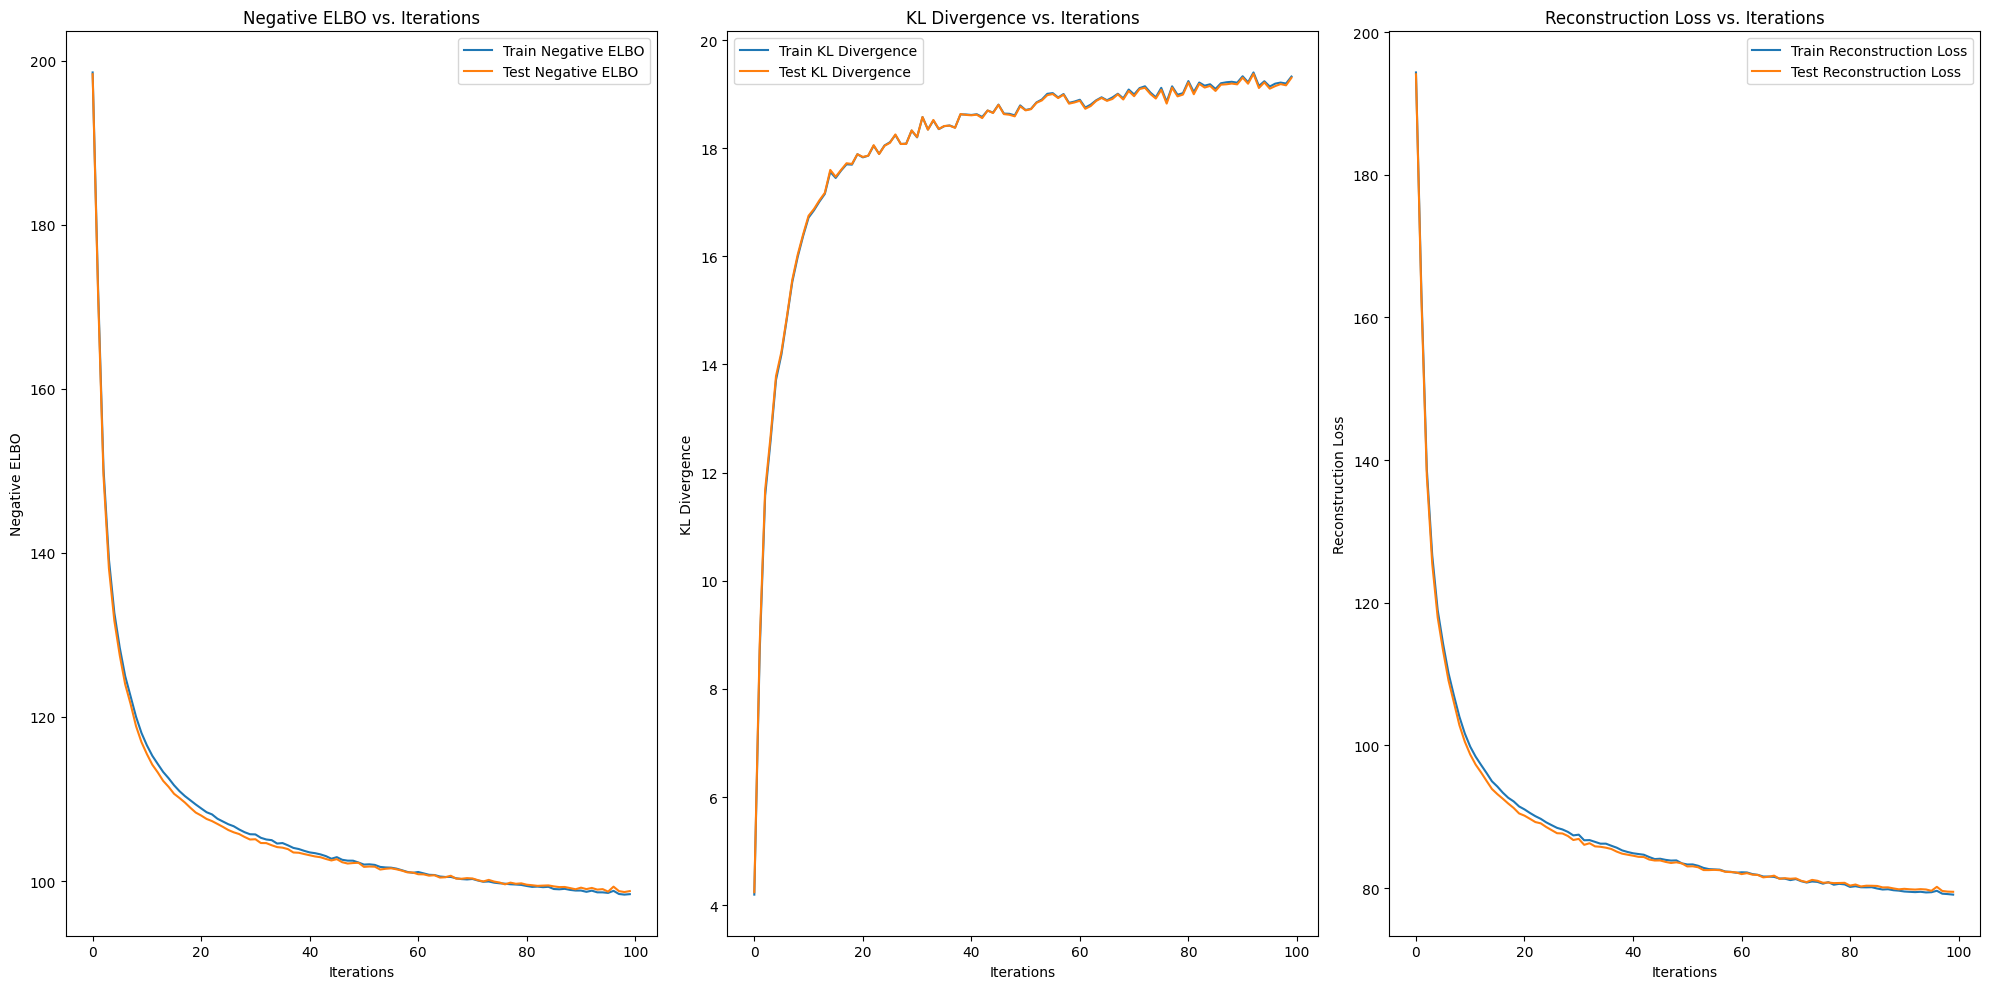

In [28]:
iterations = range(0, iter_max, 1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.plot(iterations[:len(train_losses)], train_losses, label='Train Negative ELBO')
plt.plot(iterations[:len(test_losses)], test_losses, label='Test Negative ELBO')
plt.title('Negative ELBO vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Negative ELBO')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iterations[:len(train_kls)], train_kls, label='Train KL Divergence')
plt.plot(iterations[:len(test_kls)], test_kls, label='Test KL Divergence')
plt.title('KL Divergence vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('KL Divergence')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iterations[:len(train_recs)], train_recs, label='Train Reconstruction Loss')
plt.plot(iterations[:len(test_recs)], test_recs, label='Test Reconstruction Loss')
plt.title('Reconstruction Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Reconstruction Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch

def evaluate_vae_model(vae, val_loader, m_values, num_repetitions=50, device='cuda'):
    results = {'m': [], 'niwae_avg': [], 'elbo_avg': []}

    for m in m_values:
        niwae_vals = []
        elbo_vals = []

        for _ in (range(num_repetitions)):
            for xv, _ in val_loader:
                xv = torch.bernoulli(xv.to(device).reshape(xv.size(0), -1))

                # Compute negative IWAE
                niwae, _, _ = vae.negative_iwae_bound(xv, m)
                niwae_vals.append(niwae.item())

                # Compute negative ELBO
                elbo, _, _ = vae.negative_elbo_bound(xv)
                elbo_vals.append(elbo.item())

        # Average the results
        results['m'].append(m)
        results['niwae_avg'].append(sum(niwae_vals) / len(niwae_vals))
        results['elbo_avg'].append(sum(elbo_vals) / len(elbo_vals))

    return results

def report_results(results):
    for m, niwae_avg, elbo_avg in zip(results['m'], results['niwae_avg'], results['elbo_avg']):
        print(f"m = {m}: Negative IWAE = {niwae_avg}, Negative ELBO = {elbo_avg}")



if __name__ == "__main__":

    # Load the trained VAE model
    vae = torch.load('vae_model.pth').to(device)

    # Values of m to evaluate
    m_values = [5, 50, 150]

    # Evaluate the model
    results = evaluate_vae_model(vae, test_loader, m_values)

    # Report the results
    report_results(results)


Results:
m = 5: Negative IWAE = 94.35448744812011, Negative ELBO = 96.62817235870361
m = 50: Negative IWAE = 92.95993561553955, Negative ELBO = 96.62349592590331
m = 150: Negative IWAE = 92.61229615783691, Negative ELBO = 96.63181770019531
